<a href="https://colab.research.google.com/github/seongmin0215/2025-1_CV/blob/main/%EC%BB%B4%ED%93%A8%ED%84%B0%EB%B9%84%EC%A0%84HW3_%EC%A1%B0%EC%84%B1%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실험A

In [9]:
#모듈 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#GPU 사용가능 여부 확인
if torch.cuda.is_available() :
  DEVICE = torch.device('cuda')
else :
  DEVICE = torch.device('cpu')

print('Using PyTorch version :', torch.__version__, ' Device :', DEVICE)

Using PyTorch version : 2.6.0+cu124  Device : cpu


In [11]:
#하이퍼파라미터
input_size=28*28
num_classes=10
num_epochs=30
batch_size=64 #1개 batch에 64개의 샘플
learning_rate=0.001

#데이터셋 로드
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True) #훈련 데이터
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True) #테스트 데이터
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.53MB/s]


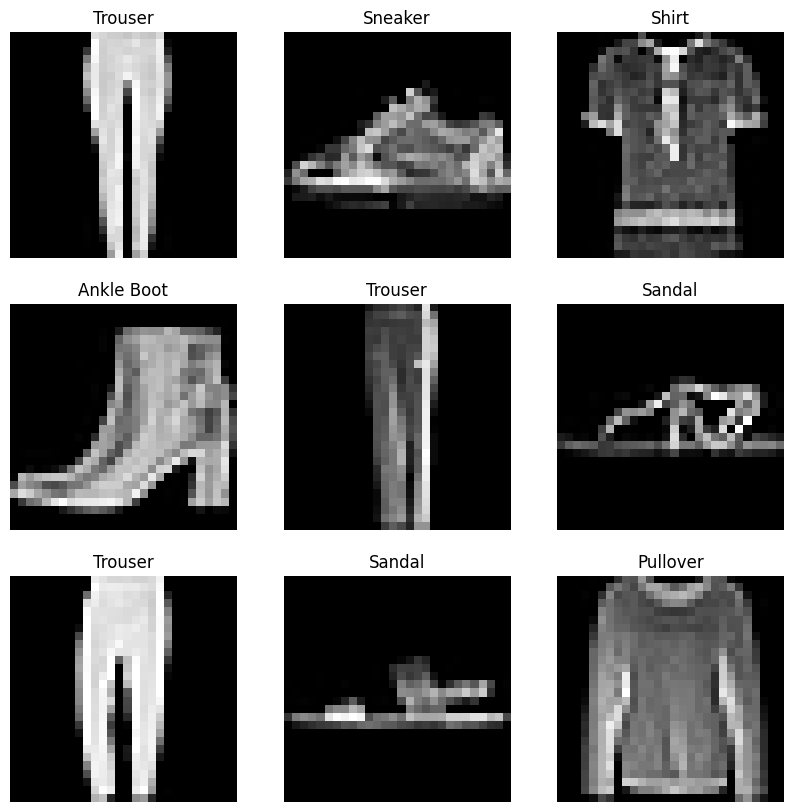

In [12]:
#이미지 확인
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [16]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential( # layer구성
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x) #forward 수행


# CrossEntropyLoss사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MLP().to(device)


# 모델 학습
def train_model_crossentropy():
    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list, train_loss_list = [], [] # 정확도 손실값 저장할 리스트
    grad_norm_list = []   # gradient norm 저장용 리스트


    for epoch in range(num_epochs): #epoch=30
        model.train() #모델을 학습하기 위해 호출되는 함수
        total, correct, running_loss = 0, 0, 0
        grad_total = 0     # 이번 epoch 전체 gradient 누적
        grad_count = 0     # gradient 대상 param 개수

        for images, labels in train_loader: #train 데이터세트에서 이미지를 한배치씩 꺼냄
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) #순전파
            loss = criterion(outputs, labels) #손실계산 / 예측이 정답을 잘 맞췄다면 손실값이 낮음
            optimizer.zero_grad() #이전 gradient 초기화
            loss.backward() # 역전파 계산

            # 여기서 gradient 측정
            batch_grad = 0
            batch_count = 0
            for param in model.parameters():
                if param.grad is not None:
                    batch_grad += param.grad.abs().mean().item()
                    batch_count += 1
            if batch_count > 0:
                grad_total += batch_grad / batch_count
                grad_count += 1


            optimizer.step() # 파라미터 업데이트


            running_loss += loss.item() * labels.size(0) # 현재 배치에서의 총 손실 값
            _, predicted = torch.max(outputs, 1) #가장 높은 값을 가진 클래스 인덱스 출력
            correct += (predicted == labels).sum().item() #정답과 예측이 같은 경우, True
            total += labels.size(0)


        epoch_loss = running_loss / total #전체 데이터셋의 손실
        epoch_acc = correct / total # 전체 데이터셋의 정확도
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        # epoch 끝난 후 평균 gradient 저장
        grad_norm_list.append(grad_total / grad_count)


        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


    return model, train_loss_list, train_acc_list,grad_norm_list  # 학습된 모델 반환

# 학습 수행
model, loss_list, acc_list, ce_grad_list = train_model_crossentropy()


Epoch [1/30], Loss: 0.5214, Accuracy: 0.8135
Epoch [2/30], Loss: 0.3727, Accuracy: 0.8643
Epoch [3/30], Loss: 0.3336, Accuracy: 0.8765
Epoch [4/30], Loss: 0.3084, Accuracy: 0.8851
Epoch [5/30], Loss: 0.2884, Accuracy: 0.8924
Epoch [6/30], Loss: 0.2746, Accuracy: 0.8965
Epoch [7/30], Loss: 0.2572, Accuracy: 0.9041
Epoch [8/30], Loss: 0.2491, Accuracy: 0.9072
Epoch [9/30], Loss: 0.2379, Accuracy: 0.9103
Epoch [10/30], Loss: 0.2265, Accuracy: 0.9138
Epoch [11/30], Loss: 0.2187, Accuracy: 0.9171
Epoch [12/30], Loss: 0.2114, Accuracy: 0.9206
Epoch [13/30], Loss: 0.2026, Accuracy: 0.9214
Epoch [14/30], Loss: 0.1946, Accuracy: 0.9264
Epoch [15/30], Loss: 0.1887, Accuracy: 0.9278
Epoch [16/30], Loss: 0.1819, Accuracy: 0.9307
Epoch [17/30], Loss: 0.1738, Accuracy: 0.9322
Epoch [18/30], Loss: 0.1656, Accuracy: 0.9365
Epoch [19/30], Loss: 0.1640, Accuracy: 0.9379
Epoch [20/30], Loss: 0.1548, Accuracy: 0.9410
Epoch [21/30], Loss: 0.1525, Accuracy: 0.9408
Epoch [22/30], Loss: 0.1448, Accuracy: 0.94

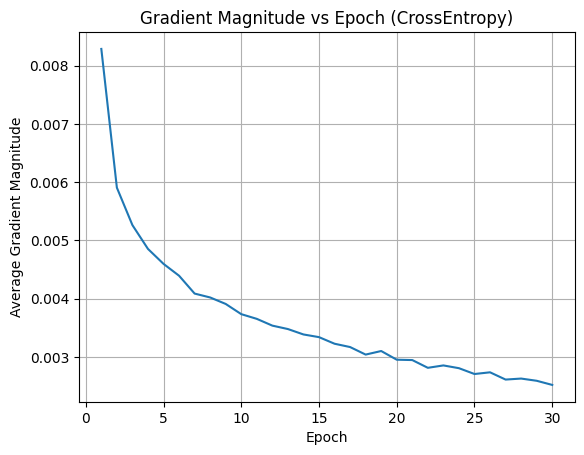

In [17]:
# gradient 그래프 그리기
plt.plot(range(1, num_epochs+1), ce_grad_list)
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Magnitude")
plt.title("Gradient Magnitude vs Epoch (CrossEntropy)")
plt.grid(True)
plt.show()

In [18]:
# 활성화 함수 초기,중간,후기 값 시각화
def plot_activation_histograms():
    for stage in ['early', 'mid', 'late']:
        relu1_act = activations[stage][0].view(-1).numpy()
        relu2_act = activations[stage][1].view(-1).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.hist(relu1_act, bins=50)
        plt.title(f"ReLU1 Activation ({stage})")

        plt.subplot(1, 2, 2)
        plt.hist(relu2_act, bins=50)
        plt.title(f"ReLU2 Activation ({stage})")

        plt.suptitle(f"{stage.capitalize()} Epoch Activations")
        plt.show()


plot_activation_histograms()

IndexError: list index out of range

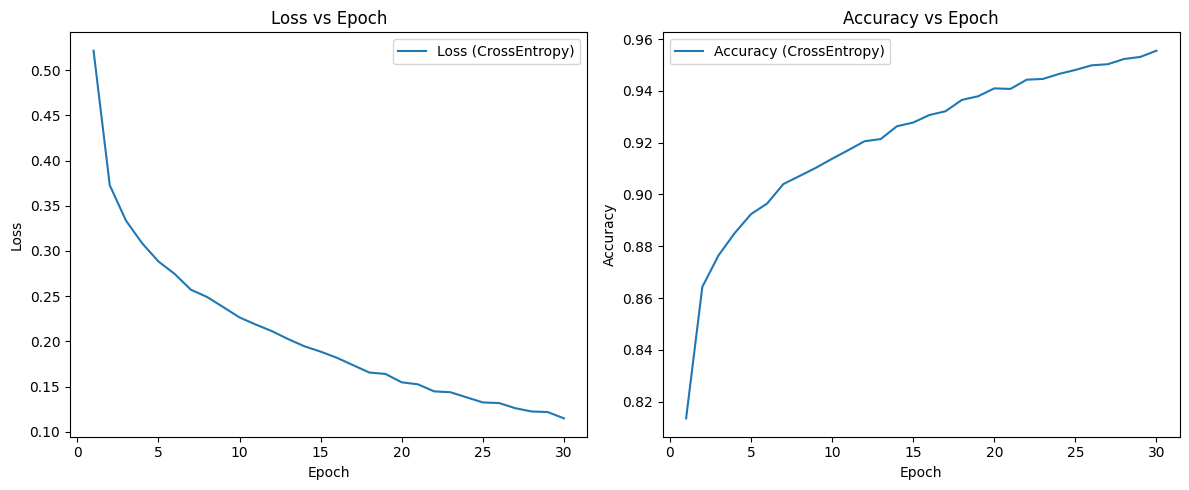

In [19]:
# 손실값, 정확도 시각화 (CrossEntropy)
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, label='Loss (CrossEntropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, label='Accuracy (CrossEntropy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


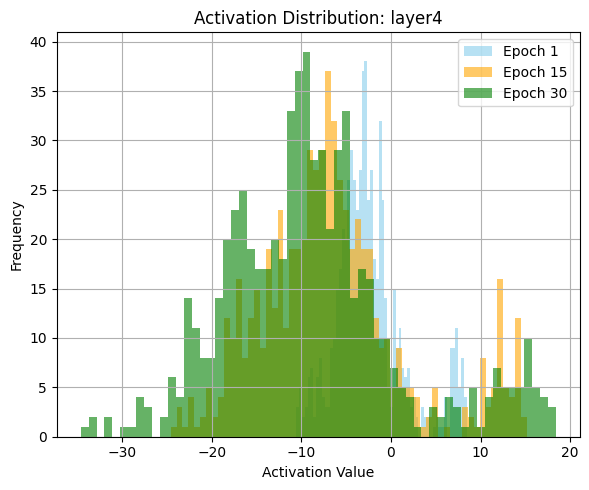

In [20]:
# Hook 결과 저장용
activations = {'early': {}, 'mid': {}, 'late': {}}

# Hook 등록 함수
def get_activation(stage, name):
    def hook(model, input, output):
        activations[stage][name] = output.detach().cpu()
    return hook


class MLP(nn.Module):
    def __init__(self, activation='sigmoid'):
        super(MLP, self).__init__()
        act_fn = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid()
        }[activation]

        self.model = nn.Sequential(
            nn.Linear(784, 256),  # layer0
            act_fn,               # layer1
            nn.Linear(256, 128),  # layer2
            act_fn,               # layer3
            nn.Linear(128, 10)    # layer4
        )

    def forward(self, x):
        return self.model(x)


def train_with_activation_tracking(train_loader, loss_type='crossentropy'):#crossentropy/mse로 변경
    model = MLP(activation='sigmoid').to(device) #활성화 함수 결정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss() if loss_type == 'crossentropy' else nn.MSELoss()#crossentropy/mse로 변경

    for epoch in range(30):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)
            if loss_type == 'crossentropy': #crossentropy/mse로 변경
                labels_onehot = F.one_hot(labels, num_classes=10).float()
                outputs = F.softmax(outputs, dim=1)
                loss = criterion(outputs, labels_onehot)
            else:
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 특정 epoch에서 hook 등록 및 값 저장
        if epoch in [0, 14, 29]:
            stage = 'early' if epoch == 0 else 'mid' if epoch == 14 else 'late'
            handles = []
            handles.append(model.model[0].register_forward_hook(get_activation(stage, 'layer0')))
            handles.append(model.model[2].register_forward_hook(get_activation(stage, 'layer2')))
            handles.append(model.model[4].register_forward_hook(get_activation(stage, 'layer4')))

            model.eval()
            with torch.no_grad():
                images, _ = next(iter(train_loader))
                images = images.to(device)
                images = images.view(images.size(0), -1)
                _ = model(images)

            for h in handles:
                h.remove()

    return model


import matplotlib.pyplot as plt



# 학습 실행
model = train_with_activation_tracking(train_loader, loss_type='crossentropy') #crossentropy/mse로 변경


# 활성화 함수 초기,중간,후기 값 시각화
def plot_activations(activations, layer_name='layer4'):
    plt.figure(figsize=(6, 5))

    for stage, color in zip(['early', 'mid', 'late'], ['skyblue', 'orange', 'green']):
        data = activations[stage][layer_name]
        flat = data.view(-1).numpy()
        plt.hist(flat, bins=60, alpha=0.6, label=f"Epoch {1 if stage=='early' else 15 if stage=='mid' else 30}", color=color)

    plt.title(f"Activation Distribution: {layer_name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 시각화
plot_activations(activations, layer_name='layer4')


In [ ]:
#MSE
#하이퍼파라미터
input_size=28*28
num_classes=10
num_epochs=30
batch_size=64 #1개 batch에 64개의 샘플
learning_rate=0.001

#데이터셋 로드
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True) #훈련 데이터
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True) #테스트 데이터
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential( # layer구성
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x) #forward 수행

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gradient_stats = {}

# MSE Loss사용
def train_model_mse():
    model = MLP().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list, train_loss_list = [], []
    grad_norm_list = []   # gradient norm 저장용 리스트


    for epoch in range(num_epochs):
        model.train()
        total, correct, running_loss = 0, 0, 0
        grad_total = 0     # 이번 epoch 전체 gradient 누적
        grad_count = 0     # gradient 대상 param 개수

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)  # Softmax 적용

            # One-hot encoding으로 변환
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

            loss = criterion(outputs, labels_onehot)

            optimizer.zero_grad()
            loss.backward()


            # 여기서 gradient 측정
            batch_grad = 0
            batch_count = 0
            for param in model.parameters():
                if param.grad is not None:
                    batch_grad += param.grad.abs().mean().item()
                    batch_count += 1
            if batch_count > 0:
                grad_total += batch_grad / batch_count
                grad_count += 1


            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        # epoch 끝난 후 평균 gradient 저장
        grad_norm_list.append(grad_total / grad_count)

        print(f'[MSE] Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return model, train_loss_list, train_acc_list, grad_norm_list



In [ ]:
# 학습 수행
mse_model, mse_loss_list, mse_acc_list, grade_list = train_model_mse()
#  gradient 그래프 그리기
plt.plot(range(1, num_epochs+1), grade_list)
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Magnitude")
plt.title("Gradient Magnitude vs Epoch (MSE)")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, mse_loss_list, label='MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (MSE)')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, mse_acc_list, label='MSE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch (MSE)')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
# 두 개의 그래프를 쌍으로 그려서 각각 해석
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, label='CE Loss')
plt.plot(epochs, mse_loss_list, label='MSE Loss')
plt.title('Loss vs Epoch') #(각기 다른 단위)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, label='CE Accuracy')
plt.plot(epochs, mse_acc_list, label='MSE Accuracy')
plt.title('Accuracy vs Epoch ') #(공통 단위)
plt.legend()



#실험B

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)


#데이터 size및 type확인
for (X_train, y_train) in train_loader :
  print('X_train :', X_train.size(), 'type :', X_train.type()) #64개 샘플, 2차원
  print('y_train :', y_train.size(), 'type :', y_train.type())
  break


X_train : torch.Size([64, 2]) type : torch.FloatTensor
y_train : torch.Size([64]) type : torch.LongTensor


In [2]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MLP_Activ(nn.Module):
    def __init__(self, activation='relu'):
        super(MLP_Activ, self).__init__()
        act_fn = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(negative_slope=0.01), #음수 기울기 값 0.01
            'sigmoid': nn.Sigmoid()
        }[activation]

        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            act_fn, #활성화 함수
            nn.Linear(64, 64),
            act_fn,
            nn.Linear(64, 2)  # 이진 분류 → 출력은 2개 (softmax X)
        )

        # 최초 weight값 초기화: 작은 std로 Dead ReLU 유도
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01) #평균이 0, 표준편차가 0.01인 분포로 설정

    def forward(self, x):
        x = self.layers(x)
        return torch.sigmoid(x)  # 여기서 최종 출력에 적용

# 활성화함수 선택 가능
model = MLP_Activ('relu').to(device)
# model = MLP_Activ('leakyrelu').to(device)
# model = MLP_Activ('sigmoid').to(device)

In [4]:
import matplotlib.pyplot as plt
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# 학습 결과 저장용 리스트
relu_loss_list = []  # epoch별 train loss 저장
relu_acc_list = []  # epoch별 accuracy 저장
activation_outputs = {}    # 각 layer별 activation 결과를 저장
gradient_magnitudes = []  # epoch별 gradient 평균 크기를 저장

#forward hook 함수 정의 (중간 레이어 출력 저장용)
def get_activation(name):
    def hook(model, input, output):
        activation_outputs[name] = output.detach().cpu()
    return hook

# 레이어 이름에 맞춰서 조정
model.layers[0].register_forward_hook(get_activation('layer1'))
model.layers[2].register_forward_hook(get_activation('layer2'))
model.layers[4].register_forward_hook(get_activation('layer4'))


# 학습 루프
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0 # 정확도/손실 계산 초기화

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)  # forward pass
        loss = criterion(outputs, y_batch) # 손실 계산

        optimizer.zero_grad() # gradient 초기화 후 역전파
        loss.backward()


        # Gradient 평균 크기 기록
        total_grad = 0.0
        total_params = 0
        for param in model.parameters():
            if param.grad is not None:
                total_grad += param.grad.abs().sum().item()  # gradient의 절댓값 합
                total_params += param.grad.numel()
        avg_grad = total_grad / total_params  # 평균 gradient 크기
        gradient_magnitudes.append(avg_grad)


        # 최적화 파라미터 업데이트
        optimizer.step()

        # 정확도 및 손실 누적
        running_loss += loss.item() * y_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

 #  epoch 종료 후 평균 손실/정확도 저장
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    relu_loss_list.append(epoch_loss)
    relu_acc_list.append(epoch_acc)

    if epoch % 10 == 0:
        print(f"[ReLU] Epoch {epoch}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")



#평가
model.eval()
with torch.no_grad():  # gradient 계산 없이 속도 향상
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        _ = model(x_batch)
        break  # 한 배치만 처리 (히트맵용)


[ReLU] Epoch 0/500 | Loss: 0.3412 | Accuracy: 0.9712
[ReLU] Epoch 10/500 | Loss: 0.3371 | Accuracy: 0.9738
[ReLU] Epoch 20/500 | Loss: 0.3338 | Accuracy: 0.9775
[ReLU] Epoch 30/500 | Loss: 0.3333 | Accuracy: 0.9800
[ReLU] Epoch 40/500 | Loss: 0.3376 | Accuracy: 0.9738
[ReLU] Epoch 50/500 | Loss: 0.3321 | Accuracy: 0.9812
[ReLU] Epoch 60/500 | Loss: 0.3324 | Accuracy: 0.9812
[ReLU] Epoch 70/500 | Loss: 0.3358 | Accuracy: 0.9762
[ReLU] Epoch 80/500 | Loss: 0.3326 | Accuracy: 0.9812
[ReLU] Epoch 90/500 | Loss: 0.3326 | Accuracy: 0.9812
[ReLU] Epoch 100/500 | Loss: 0.3317 | Accuracy: 0.9838
[ReLU] Epoch 110/500 | Loss: 0.3336 | Accuracy: 0.9800
[ReLU] Epoch 120/500 | Loss: 0.3399 | Accuracy: 0.9712
[ReLU] Epoch 130/500 | Loss: 0.3345 | Accuracy: 0.9762
[ReLU] Epoch 140/500 | Loss: 0.3315 | Accuracy: 0.9800
[ReLU] Epoch 150/500 | Loss: 0.3352 | Accuracy: 0.9775
[ReLU] Epoch 160/500 | Loss: 0.3325 | Accuracy: 0.9812
[ReLU] Epoch 170/500 | Loss: 0.3310 | Accuracy: 0.9838
[ReLU] Epoch 180/500 

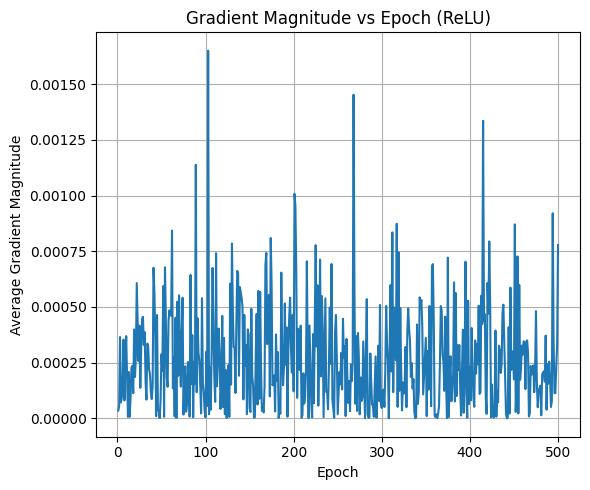

In [5]:
#gradient 시각화
plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs + 1), gradient_magnitudes[:num_epochs])
plt.title("Gradient Magnitude vs Epoch (ReLU)")
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()


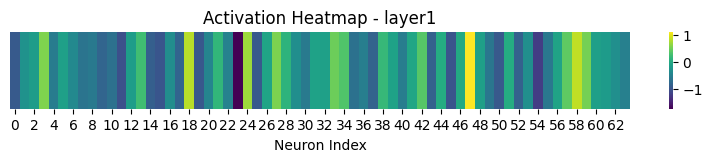

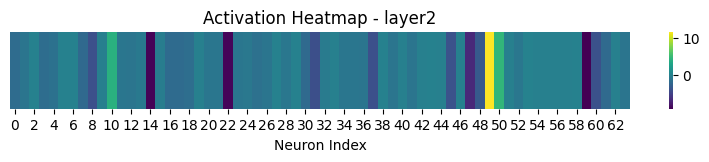

In [7]:
# 히트맵 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_activation_heatmap(layer_name):
    act = activation_outputs[layer_name]  # [batch_size, neurons]
    avg_output = act.mean(dim=0).numpy()
    plt.figure(figsize=(10, 1))
    sns.heatmap(avg_output[np.newaxis, :], cmap='viridis', cbar=True)
    plt.title(f"Activation Heatmap - {layer_name}")
    plt.xlabel("Neuron Index")
    plt.yticks([])
    plt.show()

plot_activation_heatmap('layer1')
plot_activation_heatmap('layer2')



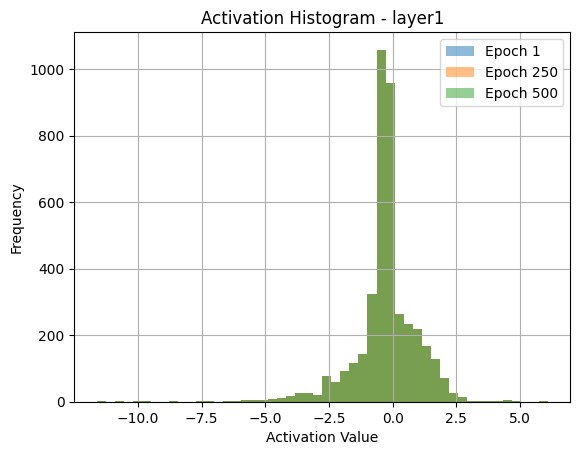

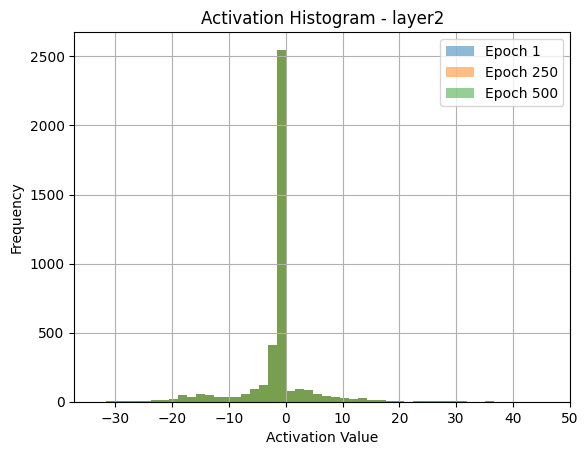

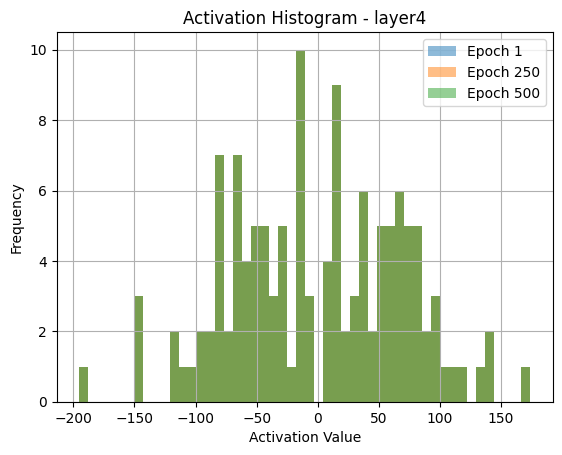

In [8]:
#활성화 함수 초기,중간,후반 값 시각화
def plot_activation_hist(layer_name, epochs=[1, 250,500]):
    for epoch in epochs:
        act = activation_outputs[layer_name].flatten().cpu().numpy()
        plt.hist(act, bins=50, alpha=0.5, label=f'Epoch {epoch}')
    plt.title(f"Activation Histogram - {layer_name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


# 사용 예
plot_activation_hist('layer1')
plot_activation_hist('layer2')
plot_activation_hist('layer4')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터셋 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의
class MLP_Activ(nn.Module):
    def __init__(self, activation='relu'):
        super(MLP_Activ, self).__init__()
        act_fn = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(negative_slope=0.01),
            'sigmoid': nn.Sigmoid()
        }[activation]

        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            act_fn,  # layer1
            nn.Linear(64, 64),
            act_fn,  # layer2
            nn.Linear(64, 2)  # 출력층
        )

        # weight 초기화 → ReLU의 dead neuron 유도
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)

    def forward(self, x):
        return self.layers(x)

# 활성화 저장용 딕셔너리
activation_outputs = {}

def get_activation(name):
    def hook(model, input, output):
        activation_outputs[name] = output.detach().cpu()
    return hook

# Dead ReLU 비율 계산 함수
def calculate_dead_relu_ratio(act_tensor):
    dead_counts = (act_tensor == 0).sum(dim=0)
    dead_neurons = (dead_counts == act_tensor.size(0)).sum().item()
    total_neurons = act_tensor.size(1)
    return round((dead_neurons / total_neurons) * 100, 2)

# 모델 생성 (활성화 함수 선택: relu, leakyrelu, sigmoid)
model = MLP_Activ(activation='leakyrelu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hook 등록
model.layers[0].register_forward_hook(get_activation('layer1'))
model.layers[2].register_forward_hook(get_activation('layer2'))

# 학습
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    if epoch % 50 == 0:
        print(f"[Epoch {epoch}] Loss: {running_loss / total:.4f}, Acc: {correct / total:.4f}")

# 평가 모드로 전환 후 forward pass (hook 작동)
model.eval()
with torch.no_grad():
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        _ = model(x_batch)
        break  # 한 배치만 사용

# Dead ReLU 비율 출력
if 'relu' in str(model.layers[1]).lower():
    dead1 = calculate_dead_relu_ratio(activation_outputs['layer1'])
    dead2 = calculate_dead_relu_ratio(activation_outputs['layer2'])

    print(f"\n✅ [Dead ReLU 비율]")
    print(f"Layer1: {dead1}%")
    print(f"Layer2: {dead2}%")
else:
    print("\n⚠️ 선택된 활성화 함수는 ReLU가 아니므로 Dead ReLU 비율이 의미 없음")


# 실험C

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_size=64, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

digits = load_digits()
X = digits.data
y = digits.target

# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)


In [ ]:
# 학습 함수 정의
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, optimizer, loss_fn, train_loader, test_loader, scheduler=None, epochs=30):
    train_loss_list, test_loss_list, accuracy_list = [], [], []
    gradient_norms = []  # gradient 흐름 추적용 /매 epoch마다 전체 gradient의 크기 (L2 norm)를 저장하는 리스트

    for epoch in range(epochs):
        model.train() # 학습 모드 전환
        total_loss = 0 # epoch 동안 누적된 train loss

        for X_batch, y_batch in train_loader: # 배치 단위 학습
            optimizer.zero_grad()  # 이전 gradient 초기화
            output = model(X_batch)  # forward pass
            loss = loss_fn(output, y_batch) # 손실 계산
            loss.backward()  # backward pass (gradient 계산)

            # ====== Gradient Norm 추적 (Vanishing/Exploding 감지용) ======
            total_grad_norm = 0.0
            for name, param in model.named_parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2) # L2 norm 계산
                    total_grad_norm += param_norm.item() ** 2 # 제곱합 누적
            total_grad_norm = total_grad_norm ** 0.5
            gradient_norms.append(total_grad_norm)
            # ===========================================================

            optimizer.step()  # weight 업데이트
            total_loss += loss.item() # train loss 누적


        if scheduler:
            scheduler.step()  # 학습률 감소

        # 평가
        model.eval()
        correct = 0
        total = 0
        test_loss = 0

        # gradient 계산 비활성화
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                loss = loss_fn(output, y_batch)
                test_loss += loss.item()
                pred = output.argmax(dim=1)  # 가장 높은 logit/예측 클래스
                correct += (pred == y_batch).sum().item()  # 정확도 계산
                total += y_batch.size(0)

        # 결과 저장
        train_loss_list.append(total_loss / len(train_loader))
        test_loss_list.append(test_loss / len(test_loader))
        accuracy_list.append(correct / total)

        avg_train_loss = total_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        acc = correct / total

        #최적화 선택
        # if opt_name == "SGD":
            # print(f"[SGD lr={lr}] Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {acc*100:.2f}%")

        if opt_name == "SGD+Momentum":
            print(f"[SGD+Momentum lr={lr}] Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {acc*100:.2f}%")


        # if opt_name == "Adam":
        #     print(f"[Adam lr={lr}] Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {acc*100:.2f}%")


    return train_loss_list, test_loss_list, accuracy_list, gradient_norms



# 공통 설정
loss_fn = nn.CrossEntropyLoss()
learning_rates = [0.01, 0.001, 0.1] #학습률 설정
optimizers = {
    "SGD": lambda params, lr: optim.SGD(params, lr=lr),
    #"SGD+Momentum": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    #"Adam": lambda params, lr: optim.Adam(params, lr=lr)
}

results = {}

for opt_name, opt_func in optimizers.items():
    for lr in learning_rates:
        model = SimpleMLP(input_size=64, num_classes=10)
        optimizer = opt_func(model.parameters(), lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  # optional
        train_loss, test_loss, acc, grad_norm = train(model, optimizer, loss_fn, train_loader, test_loader, scheduler, epochs=30)
        key = f"{opt_name}_lr{lr}"
        results[key] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "accuracy": acc,
            "grad_norm": grad_norm
        }


# Gradient Norm 시각화
plt.figure()
for key, val in results.items():
    plt.plot(val["grad_norm"], label=key)
plt.title("Gradient Norm vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Gradient L2 Norm")
plt.legend()
plt.show()



In [ ]:
# 3) Layer 별 Activation의 분포가 학습 중 어떻게 변화하는가?
#  - 초반, 중반, 후반 학습 시 활성화 함수 (ReLU, Sigmoid) 값의 분포를 시각화하고 분석하세요.

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_size=64, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),  # fc1
            nn.ReLU(), #relu로 설정
            nn.Linear(256, 128),        # fc2
            nn.ReLU(),
            nn.Linear(128, num_classes) # fc3
        )

    def forward(self, x):
        return self.model(x)


#Hook 등록용 함수
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

# 학습 함수 (activation 저장 포함)
def train(model, optimizer, loss_fn, train_loader, test_loader, scheduler=None, epochs=30):
    train_loss_list, test_loss_list, accuracy_list = [], [], []

    # Hook 등록
    model.model[0].register_forward_hook(get_activation('fc1'))
    model.model[2].register_forward_hook(get_activation('fc2'))

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if scheduler:
            scheduler.step()

        # 평가
        model.eval()
        correct, total, test_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                loss = loss_fn(output, y_batch)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += (pred == y_batch).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        train_loss_list.append(total_loss / len(train_loader))
        test_loss_list.append(test_loss / len(test_loader))
        accuracy_list.append(acc)

       # print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc*100:.2f}%")

        # Activation 저장 (초기/중간/후기)
        if epoch in [0, 14, 29]:
            model.eval()
            with torch.no_grad():
                for X_batch, _ in train_loader:
                    _ = model(X_batch)
                    break  # 한 배치만
                for layer_name, act in activations.items():
                    torch.save(act, f'activations_{layer_name}_epoch{epoch+1}.pt')

    return train_loss_list, test_loss_list, accuracy_list


# 시각화 함수
def plot_activations(layer_name, epochs=[1, 15, 30]):
    for epoch in epochs:
        act = torch.load(f'activations_{layer_name}_epoch{epoch}.pt').flatten().numpy()
        plt.hist(act, bins=100, alpha=0.6, label=f'Epoch {epoch}')
    plt.title(f'Activation Distribution: {layer_name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


# 학습 실행
model = SimpleMLP()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #모멘텀 적용
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam
loss_fn = nn.CrossEntropyLoss() #crossentropy사용

train(model, optimizer, loss_fn, train_loader, test_loader) #학습 시작

# 활성화 분포 시각화
plot_activations('fc1')
plot_activations('fc2')


In [ ]:
import matplotlib.pyplot as plt

for key, val in results.items():
    plt.plot(val["accuracy"], label=key)
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Train Loss 시각화
plt.figure()
for key, val in results.items():
    plt.plot(val["train_loss"], label=key)
plt.title("Train Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.show()

# Test Loss 시각화
plt.figure()
for key, val in results.items():
    plt.plot(val["test_loss"], label=key)
plt.title("Test Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.legend()
plt.show()


In [ ]:
# 5) Optimizer가 동일한 네트워크에서 서로 다른 학습 패턴을 보이는 이유는?
# 수동 Adam Optimizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# MLP 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class ManualAdam:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(parameters)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0
        self.m_vals = []
        self.v_vals = []

    def step(self, grads):
        self.t += 1
        m_sum, v_sum = 0, 0
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad ** 2

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            update = self.lr * m_hat / (v_hat.sqrt() + self.eps)
            with torch.no_grad():
                param -= update

            m_sum += m_hat.abs().mean().item()
            v_sum += v_hat.abs().mean().item()

        self.m_vals.append(m_sum / len(self.params))
        self.v_vals.append(v_sum / len(self.params))

# 학습 함수
def train(model, optimizer, data_loader, loss_fn, epochs=1):
    model.train()
    for _ in range(epochs):
        for x, y in data_loader:
            output = model(x)
            loss = loss_fn(output, y)

            grads = torch.autograd.grad(loss, list(model.parameters()), create_graph=False)
            optimizer.step(grads)

# 데이터셋 (작은 subset으로 제한)
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
small_subset = Subset(dataset, range(0, 512))
data_loader = DataLoader(small_subset, batch_size=32, shuffle=True)

# 실행
model = SimpleMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = ManualAdam(model.parameters(), lr=0.001)
train(model, optimizer, data_loader, loss_fn, epochs=1)

# 시각화
plt.plot(optimizer.m_vals, label="m (1st moment)")
plt.plot(optimizer.v_vals, label="v (2nd moment)")
plt.title("Manual Adam - Moment Tracking")
plt.xlabel("Iteration")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.show()